In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

/home/uichan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.datasets as dset #데이터셋, 모델, 이미지 포함
import torchvision.transforms as transforms #불러온 이미지의 변환
from torch.utils.data import DataLoader #배치사이즈대로 묶어서 전달할때 묶거나 섞을 수 있는 클래스

/home/uichan/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm

In [4]:
#download mnist
mnist_train = dset.MNIST(root='./data/mnist', train=True, transform=transforms.ToTensor(),target_transform=None ,download=True)
mnist_test  = dset.MNIST(root='./data/mnist', train=False, transform=transforms.ToTensor(),target_transform=None ,download=True)

train_loadaer = DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=2, drop_last = True)
test_loader   = DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=2, drop_last = True)
print("download 완료!")

download 완료!


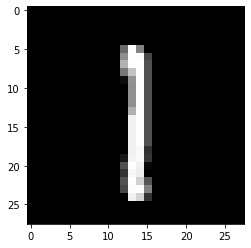

label : 1
shape : torch.Size([1, 28, 28])


In [5]:
#check data
random_num = np.random.randint(0, 10000)
plt.imshow(mnist_test[random_num][0].reshape(-1,28),cmap="gray")
plt.show()
print(f"label : {mnist_test[random_num][1]}")
print(f"shape : {mnist_test[random_num][0].shape}")

In [6]:
lr = 0.00002
num_epoch = 1000

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            #conv
            nn.Conv2d(1,16,5), # 28 -> 24
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 24 -> 20
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 20 -> 10
            nn.Conv2d(32,64,5), # 10 -> 6
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 6 -> 3
        )

        self.fc = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr)

/home/uichan/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3070 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [9]:
loss_arr = []
for i in tqdm(range(num_epoch)):
    loss_sum = 0
    for [image,label] in test_loader:  #enumerate 사용시 인덱스와 튜플을 같이 넘겨줌
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        _,output_max = torch.max(output,1)

        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.cpu().detach().numpy()
    loss_arr.append(loss_sum)
    

print("train 완료!")
        


  0%|          | 0/1000 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fab6107ab80>
Traceback (most recent call last):
  File "/home/uichan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1509, in __del__
    def __del__(self):
KeyboardInterrupt: 
  0%|          | 0/1000 [01:15<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

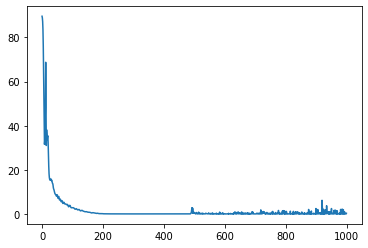

0.28839111328125


In [ ]:
#print loss
plt.plot(loss_arr)
plt.show()
print(loss_arr[-1])

In [ ]:
#검증

total = 0
correct = 0

with torch.no_grad():
    for image,label in test_loader:
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        _,output_max = torch.max(output,1)
        
        total += label.size(0)
        correct += (output_max == y).sum()

print(f"total    : {total}")
print(f"correct  : {correct.cpu().numpy()}")
print(f"accuracy : {correct/total*100:.3}%")
        

total    : 9984
correct  : 9984
accuracy : 1e+02%


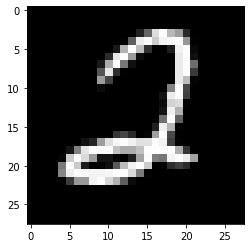

label : 2
infer : 2
True


In [ ]:
#이미지 확인

random_num = np.random.randint(0, 10000)
image = mnist_test[random_num][0]

plt.imshow(image.reshape(-1,28),cmap="gray")
plt.show()
print(f"label : {mnist_test[random_num][1]}")
#infer
with torch.no_grad():
    output = model.forward(image.reshape([1,1,28,28]).to(device))
    _,output_max = torch.max(output,1)

print(f"infer : {int(output_max)}")
print(int(output_max)==mnist_test[random_num][1])



In [ ]:
#틀렸을때의 출력
val = True
count = 0

while val:
    count+=1
    random_num = np.random.randint(0, 10000)
    image = mnist_test[random_num][0]
    
    #infer
    with torch.no_grad():
        output = model.forward(image.reshape([1,1,28,28]).to(device))
        _,output_max = torch.max(output,1)

    val = int(output_max)==mnist_test[random_num][1]

plt.imshow(image.reshape(-1,28),cmap="gray")
plt.show()
print(f"count : {count}")
print("------------------")
print(f"label : {mnist_test[random_num][1]}")
print(f"infer : {int(output_max)}")
print(int(output_max)==mnist_test[random_num][1])